# Comparing Performance of Support-Vector Machine and Logistic Regression

## Description of Task

This notebook is a solution to the following task:

Compare the performance of a Support-Vector Machine with that of Logistic Regression.
Try to optimize both algorithms' parameters and determine which one is best for thisdataset. 
At the end of the analysis, you should have chosen an algorithm and its optimal set of parameters:
write this choice explicitly in the conclusions of your notebook.

## Description of Dataset

This dataset is composed of 1300 samples with 25 features each. 
The first column is the sample id. The second column in the dataset represents the label. 
There are 2 possible values for the labels. The remaining columns are numeric features.


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

### Importing Dataset:


In [ ]:
df = pd.read_csv('mldata.csv')
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)
df.set_index('index', inplace=True)

# Formatting
print(f"""{'#Observations':>13}  {'#Features':>9}  {'#NA Values':>12}  {'#Duplicates':>6}  {'label':>7} 
{'-' * 64}""")
print("{:>13}  {:>9}  {:>12}       {:>6}  {:>6.1F} %".format(
    df.shape[0],
    df.shape[1] - 1,
    df.count().sum() - df.shape[0] * df.shape[1] or "None",
    df.duplicated().sum() or "None",
    df['label'].mean() * 100
))


#Observations  #Features    #NA Values  #Duplicates    label 
----------------------------------------------------------------
         1300         25          None         None    49.7 %


This quickly verifies that we have 1300 observations and 25 features. In addition, we see that there are no NA value or duplicated rows and that there is a ~50:50 proportion between the two labels in the dataset. Next, let's perform some dataset analysis.

### Exploratory Data Analysis

In this section we will perform brief exploration into our data, looking at summary statistics, plotting the histogram spread of each feature, and looking at the correlation between each feature. This will help us to understand what the nature of the data and give us the opportunity to notice relationships in the data.

In [53]:
df_features = df.columns[df.columns != 'label']
df[df_features].describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,-0.338439,-0.151954,-0.185151,0.311299,0.279897,0.003881,0.178295,-0.542319,0.002054,-0.004932,...,-0.429254,-0.347421,-0.502387,0.433979,0.204415,-0.582756,-1.053712,0.107390,-0.032372,-0.374981
std,1.427770,1.670306,0.981991,2.404899,1.223137,1.136962,1.051852,1.701212,1.200918,1.043793,...,1.861464,1.435908,1.197181,2.039115,1.199795,0.666962,2.567385,1.100071,1.963108,1.321986
min,-5.577567,-6.132911,-3.953686,-8.213834,-3.473453,-4.393443,-3.724541,-5.207074,-4.245091,-3.596323,...,-8.235007,-4.290421,-5.107172,-5.532940,-4.604010,-2.660711,-11.418329,-3.258889,-6.199655,-4.451162
25%,-1.211653,-1.213953,-0.827902,-1.101432,-0.557659,-0.720631,-0.580719,-1.774042,-0.809177,-0.701703,...,-1.537929,-1.293797,-1.256219,-1.062781,-0.572558,-1.034037,-2.328044,-0.625966,-1.419217,-1.263837
50%,-0.248385,-0.031338,-0.155223,0.535549,0.231154,-0.039458,0.139593,-0.575434,0.039064,-0.010828,...,-0.384438,-0.331566,-0.463897,0.551644,0.237767,-0.570126,-0.624524,0.079981,-0.016846,-0.378328
75%,0.640682,0.916374,0.530636,2.052738,1.067619,0.772724,0.886920,0.562960,0.798489,0.686624,...,0.775868,0.562251,0.306079,1.949728,1.016510,-0.132454,0.632363,0.838287,1.310980,0.439124
max,3.720374,5.298651,2.773804,6.133258,4.615081,4.220863,3.983645,5.448051,3.626921,3.492904,...,5.370952,4.217335,3.630840,5.730333,4.078821,1.407933,5.377527,3.244948,8.961113,6.407959


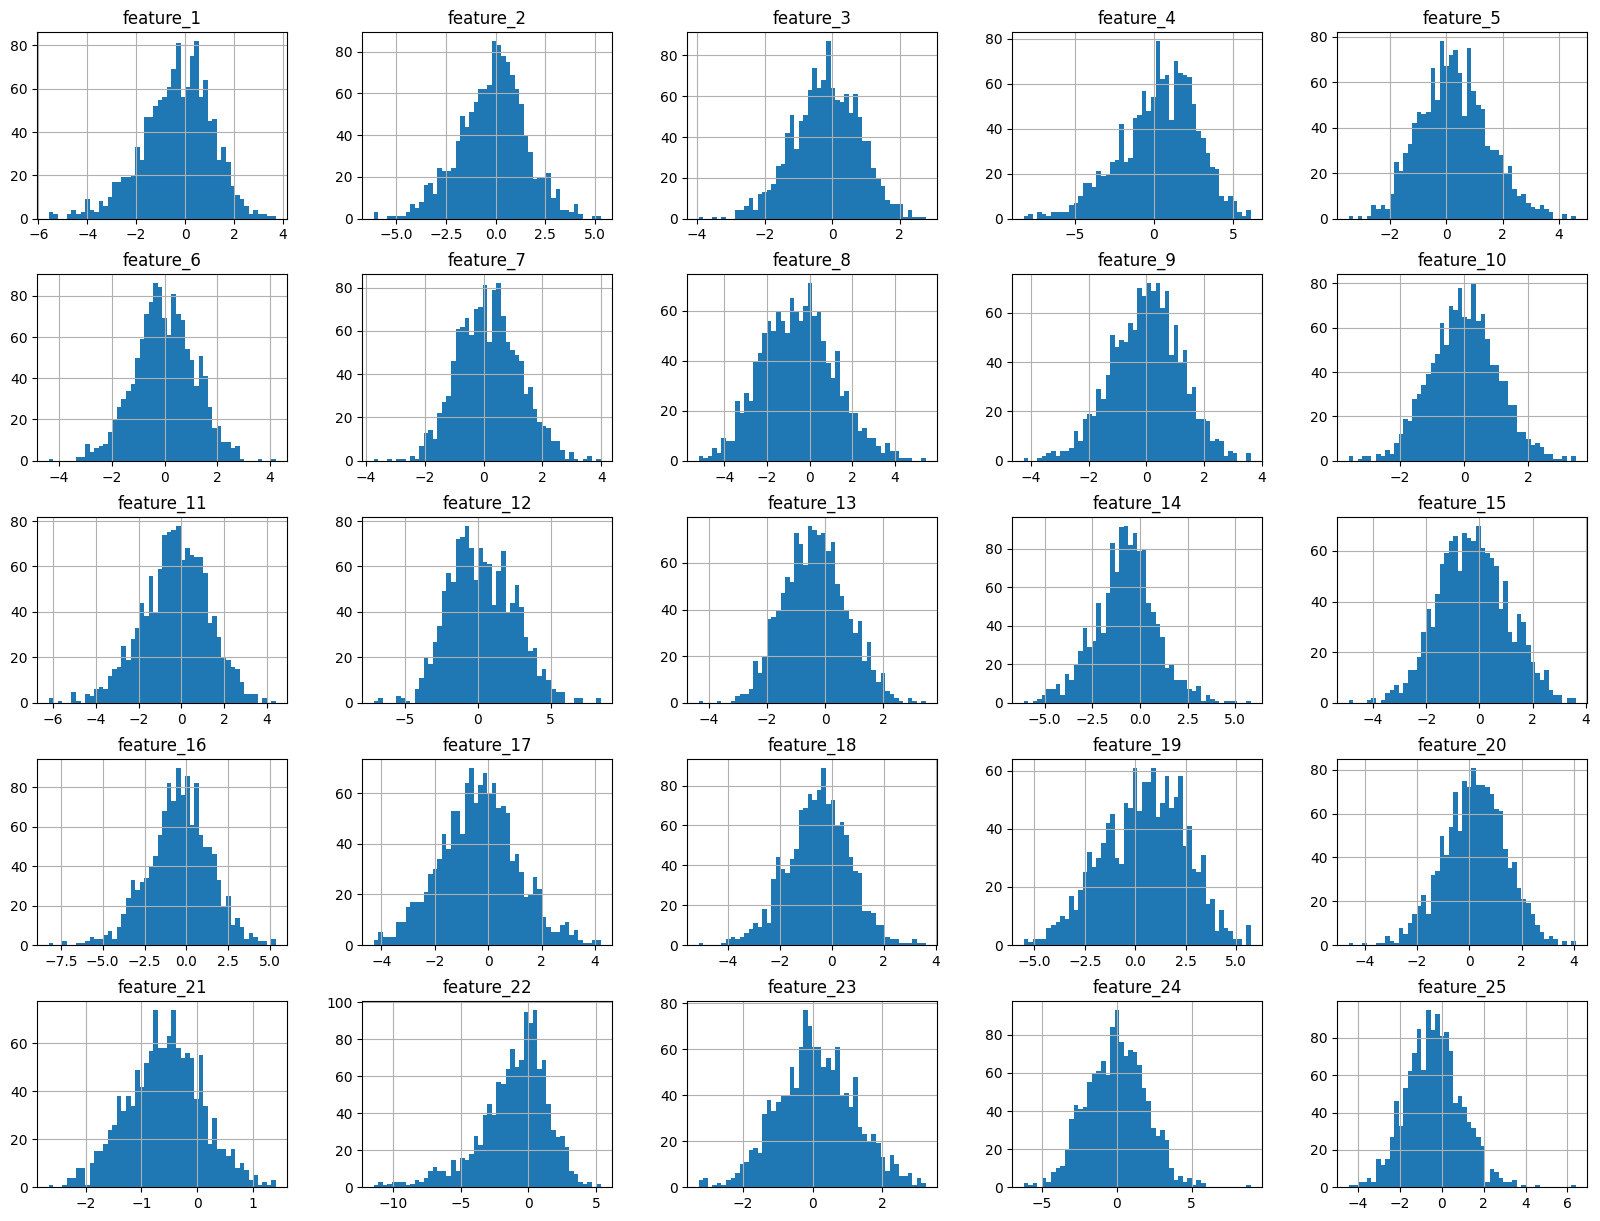

In [54]:
# Histograms of the features
df[df_features].hist(bins=50, figsize=(20, 15));

From the histograms and summary statistics we can see that we have symmetrical data. In addition, we can see that our data is normally distributed with mean near 0 and a standard deviation of most 2.6. Next, the correlation heatmap will tell us how our features relate to one another.

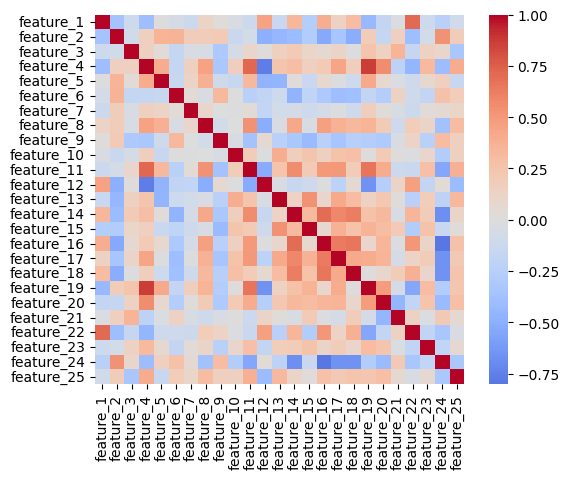

In [55]:
# Correlation matrix with heatmap
corr_matrix = df[df_features].corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True);


### Unsupervised Learning

Next, we can perform Principal Component Analysis to look at how much we can reduce dimensions and retain the information of our data. We will look at how many components are needed to retain the data's variance, specifically looking at 80, 90, and 95 % variance. We will also then plot the variance explained by each component to see a visual representation of this.

In [56]:
# Function for PCA returning a result dictionary

def apply_pca(df, variance_threshold = 0.95):
    df_features = df.columns[df.columns != 'label']
    scaler = StandardScaler()
    X = scaler.fit_transform(df[df_features])
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    X_pca = pca.fit_transform(df)

    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    pca_df = pd.DataFrame(X_pca, columns=pca_columns)

    return {
        'variance_threshold': variance_threshold,
        'transformed_data': pca_df,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'cumulative_explained_variance': np.cumsum(pca.explained_variance_ratio_),
        'components': pca.components_,
        'n_components': pca.n_components_,
    }

feature_df = df[df_features]

# Formatting
print(f"""{'Variance Explained':^25} {'#Components':^15} {'Dimensionality Kept':^20}""")
print("---------------------------------------------------------------")
for explained_variance in (.80, .90, .95):
    pca_result = apply_pca(feature_df, variance_threshold = explained_variance)
    print("{:^25.0%} {:^15} {:^20.2%}".format(
        explained_variance,
        pca_result['n_components'],
        pca_result['n_components'] / feature_df.shape[1]
    ))

   Variance Explained       #Components   Dimensionality Kept 
---------------------------------------------------------------
           80%                   7               28.00%       
           90%                  13               52.00%       
           95%                  16               64.00%       


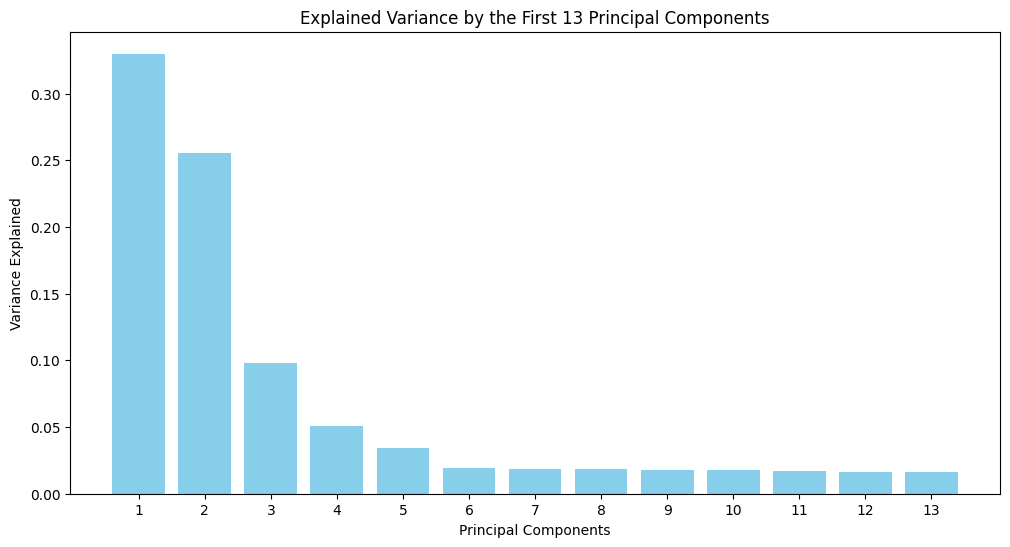

In [57]:
# Function to plot the explained variance
def plot_all_explained_variance(pca_results):
    explained_variance = pca_results['explained_variance_ratio']
    n_components = min(len(explained_variance),50)
    components = range(1, n_components + 1)

    plt.figure(figsize=(12, 6))
    plt.bar(components, explained_variance[:n_components], color='skyblue')
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.title(f"Explained Variance by the First {n_components} Principal Components")
    plt.xticks(components)
    plt.show()

plot_all_explained_variance(apply_pca(feature_df, 0.9))


Now that we have reduced the data, we can take our first three principal components and plot the points in the space spanned by these three components. We are also going to color the points according to their label to see if there is a clear split between the two labels of the data.

/var/folders/9g/q67r0bss7297jh57g7_vdqsm0000gn/T/ipykernel_18456/1211001677.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


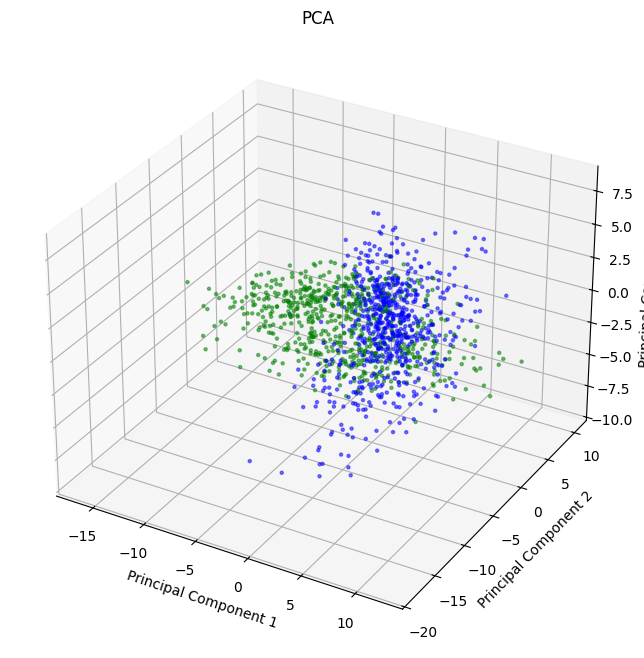

In [58]:
# Function to plot the data using the first three principal components
def dataset_PCA_components_3d_scatter(df):
    f = plt.figure(figsize=(10, 8))
    ax = f.add_subplot(111, projection = '3d')

    pca = PCA(n_components=3)
    pca.fit_transform(df.iloc[1:])

    labels = df['label']
    colors = ['green' if label == 1 else 'blue' for label in labels]

    ax.scatter(*(np.asmatrix(pca.components_) * df.T.to_numpy()),
               c=colors,
               s=5, alpha=.5)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_title(f"PCA")
    f.show()

dataset_PCA_components_3d_scatter(df)

### Supervised Learning

Now that we have some idea of the nature of our data, we can move on to our models.

Let us prepare and scale the data and define our models. We will be using logistic regression, support vector machine with a linear kernel, and then we will extend our analysis to SVM with other kernels too.

In [59]:
# Setting up the dataframe
df_features = df.columns[df.columns != 'label']
X = df[df_features]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Helper function to set up classifiers with GridSearch
def Classifier_GridSearch(classifier, X_train, y_train, X_test, y_test, param_grid):
    match classifier:
        case 'logr':
            estimator = LogisticRegression(max_iter=20000, solver='saga', penalty='elasticnet', class_weight='balanced', random_state=42)
        case 'lsvc':
            estimator = LinearSVC(max_iter=20000, dual=False, class_weight='balanced', random_state=42)
        case 'svc':
            estimator = SVC(max_iter=20000, class_weight='balanced', random_state=42, tol=1e-3)
        case _:
            raise ValueError("Invalid classifier type. Please choose from 'logr', 'lsvc', or 'svc'.")
    
    grid = GridSearchCV(estimator, param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

# Helper function to print the results of the GridSearch
def GridSearch_Results(grid, param_grid):
    results = grid.cv_results_
    results_df = pd.DataFrame(results)

    param_columns = [f'param_{key}' for key in param_grid.keys()]
    param_columns.extend(['mean_test_score', 'rank_test_score'])
    print(results_df[param_columns])
    
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best score: {grid.best_score_}")
    best_model = grid.best_estimator_
    return best_model

# Helper function to get the accuracy of the best model
def Get_Accuracy(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

### Logistic Regression

In our parameter grid we will experiment with different values for C, varying the regularization of the classifier, as well as the l1_ratio, which weighs our l1 vs l2 norms regularization.

In [60]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.5, 0.7, 0.9]
    }


# Running GridSearchCV
logr = Classifier_GridSearch('logr', X_train, y_train, X_test, y_test, param_grid)
logr_best_model = GridSearch_Results(logr, param_grid)

    param_C  param_l1_ratio  mean_test_score  rank_test_score
0      0.01             0.5         0.811538               10
1      0.01             0.7         0.791346               11
2      0.01             0.9         0.782692               12
3      0.10             0.5         0.823077                1
4      0.10             0.7         0.822115                2
5      0.10             0.9         0.817308                8
6      1.00             0.5         0.821154                6
7      1.00             0.7         0.818269                7
8      1.00             0.9         0.817308                8
9     10.00             0.5         0.822115                2
10    10.00             0.7         0.822115                2
11    10.00             0.9         0.822115                2
Best parameters: {'C': 0.1, 'l1_ratio': 0.5}
Best score: 0.823076923076923


The logistic regression gives us a score of 0.82, which is a good start, but let's try to make use of polynomial features to see if this will give us a clearer split in our data.
Logistic regression (and LSVC) works best with linearly separable data. Through polynomial features, we perform a nonlinear transformation of the data which might facilitate finding this linear separation. 

In [ ]:
# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)  # Adjust degree as needed
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Scale the data
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Define the parameter grid, 0.3 and 0.5 added after seeing 0.1 performed well
param_grid = {
    'C': [0.1, 0.3, 0.5],
    'l1_ratio': [0.5, 0.7, 0.9]
}

#Running GridSearchCV
poly_logr = Classifier_GridSearch('logr', X_train_poly, y_train, X_test_poly, y_test, param_grid)
poly_logr_best_model = GridSearch_Results(poly_logr, param_grid)


Indeed, we notice an improved performance of 0.94. Note that the initial values for the C parameter were [0.01, 0.1, 1, 10], yet upon seeing that 0.1 performed the best, I decided to look around 0.1, changing to [0.1, 0.3, 0.5].


### Support Vector Machine (linear kernel)

Next, let's move to the linear kernel Support Vector Machine, where again we experiment with the C parameter, and this time with the l1 and l2 penalties separately.

In [ ]:
# Define the grid for LinearSVC
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

lsvc = Classifier_GridSearch('lsvc', X_train, y_train, X_test, y_test, param_grid)
lsvc_best_model = GridSearch_Results(lsvc, param_grid)

   param_C param_penalty  mean_test_score  rank_test_score
0     0.01            l1         0.811538               10
1     0.01            l2         0.818269                9
2     0.10            l1         0.819231                8
3     0.10            l2         0.824038                1
4     1.00            l1         0.822115                7
5     1.00            l2         0.824038                1
6    10.00            l1         0.824038                1
7    10.00            l2         0.824038                1
8   100.00            l1         0.824038                1
9   100.00            l2         0.824038                1
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.8240384615384615


As expected, given both classifiers are geared towards linearly separable data, we see a similar performance for the LinearSVC on the basic data.As we did for Logistic Regression, let's try performing LinearSVC on polynomial features as well.

In [ ]:
# Define the parameter grid for the polynomial features
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2']
}

#Running GridSearchCV
poly_lsvc = Classifier_GridSearch('lsvc', X_train_poly, y_train, X_test_poly, y_test, param_grid)
poly_lsvc_best_model = GridSearch_Results(poly_lsvc, param_grid)

   param_C param_penalty  mean_test_score  rank_test_score
0     0.01            l1         0.909615                3
1     0.01            l2         0.932692                2
2     0.10            l1         0.944231                1
3     0.10            l2         0.896154                4
4     1.00            l1         0.888462                5
5     1.00            l2         0.874038                6
6    10.00            l1         0.867308                7
7    10.00            l2         0.865385                9
8   100.00            l1         0.866346                8
9   100.00            l2         0.864423               10
Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best score: 0.9442307692307692


Again, a better performance on the polynomial features. Given that so far we have only looked at linear kernel, let's expand our exploration to the Gaussian and sigmoid kernels.

### Support Vector Machine

In our parameter grid we will define the regularization parameter and the kernel, we will use the default values for gamma.

In [ ]:
# Define parameter grid for SVC
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid', 'poly'],
}

svc = Classifier_GridSearch('svc', X_train, y_train, X_test, y_test, param_grid)
svc_best_model = GridSearch_Results(svc, param_grid)

    param_C param_kernel  mean_test_score  rank_test_score
0      0.01          rbf         0.707692               14
1      0.01      sigmoid         0.799038               10
2      0.01         poly         0.630769               15
3      0.10          rbf         0.902885                4
4      0.10      sigmoid         0.802885                9
5      0.10         poly         0.821154                8
6      1.00          rbf         0.934615                1
7      1.00      sigmoid         0.740385               11
8      1.00         poly         0.874038                5
9     10.00          rbf         0.929808                2
10    10.00      sigmoid         0.712500               13
11    10.00         poly         0.850962                6
12   100.00          rbf         0.914423                3
13   100.00      sigmoid         0.720192               12
14   100.00         poly         0.828846                7
Best parameters: {'C': 1, 'kernel': 'rbf'}
Best score: 0

Not quite as good as the linear kernel, put a good performance nonetheless. Next, let's take the better performing kernel, rbf, and let's try a few different gamma values:

In [ ]:
# Define parameter grid with different gamma values for rbf
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.01, 0.1, 1],
}

svc_rbf = Classifier_GridSearch('svc', X_train, y_train, X_test, y_test, param_grid)
svc_rbf_best_model = GridSearch_Results(svc_rbf, param_grid)

    param_C param_kernel  param_gamma  mean_test_score  rank_test_score
0      0.01          rbf         0.01         0.635577                9
1      0.01          rbf         0.10         0.581731               10
2      0.01          rbf         1.00         0.499038               14
3      0.10          rbf         0.01         0.843269                8
4      0.10          rbf         0.10         0.891346                7
5      0.10          rbf         1.00         0.499038               14
6      1.00          rbf         0.01         0.898077                6
7      1.00          rbf         0.10         0.928846                2
8      1.00          rbf         1.00         0.562500               11
9     10.00          rbf         0.01         0.931731                1
10    10.00          rbf         0.10         0.924038                3
11    10.00          rbf         1.00         0.562500               11
12   100.00          rbf         0.01         0.922115          

## Performance

Having performed GridSearch to find the best parameters for different variations of our models, let's plot all of our models' ROC curve:

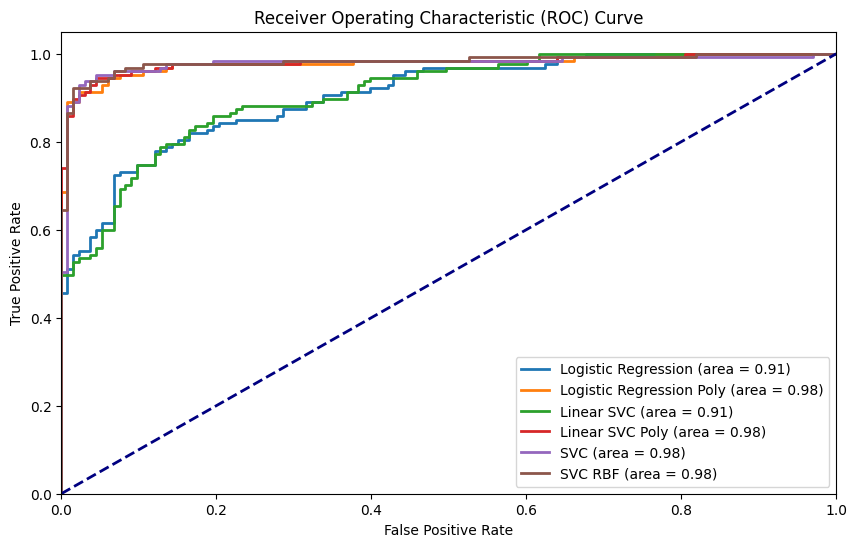

In [ ]:
def plot_multiple_rocs(models, X_test, X_test_poly, y_test, model_labels):
    plt.figure(figsize=(10, 6))
    
    for model, label in zip(models, model_labels):
        if 'poly' in label.lower():
            y_scores = model.decision_function(X_test_poly)
        else:
            y_scores = model.decision_function(X_test)
        
        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

models = [logr_best_model, poly_logr_best_model, lsvc_best_model, poly_lsvc_best_model, svc_best_model, svc_rbf_best_model]
model_labels = ['Logistic Regression', 'Logistic Regression Poly', 'Linear SVC', 'Linear SVC Poly', 'SVC', 'SVC RBF']

plot_multiple_rocs(models, X_test, X_test_poly, y_test, model_labels)

Finally let's rank all of our models:

In [ ]:
# Calculating accuracy for each model
logr_accuracy = Get_Accuracy(logr_best_model, X_test, y_test)
lsvc_accuracy = Get_Accuracy(lsvc_best_model, X_test, y_test)
svc_accuracy = Get_Accuracy(svc_best_model, X_test, y_test)
svc_rbf_accuracy = Get_Accuracy(svc_rbf_best_model, X_test, y_test)
poly_logr_accuracy = Get_Accuracy(poly_logr_best_model, X_test_poly, y_test)
poly_lsvc_accuracy = Get_Accuracy(poly_lsvc_best_model, X_test_poly, y_test)

size = 30
model_performance = [
    {"Classifier": "Logistic Regression     ".ljust(size), "Performance": logr_accuracy},
    {"Classifier": "Logistic Reg Polynomial Features".ljust(size), "Performance": poly_logr_accuracy},
    {"Classifier": "LinearSVC".ljust(size), "Performance": lsvc_accuracy},
    {"Classifier": "LinearSVC Polynomial Features".ljust(size), "Performance": poly_lsvc_accuracy},
    {"Classifier": "Support Vector Machine".ljust(size), "Performance": svc_accuracy}, # Note rbf kernel had best performance
    {"Classifier": "SVM w/ RBF Kernel Detailed".ljust(size), "Performance": svc_rbf_accuracy} # Here we explored differnet gamma values for rbf
]

# Sort models based on their accuracy
sorted_models = sorted(model_performance, key=lambda x: x["Performance"], reverse=True)

# Print the rankings
print("Position\t| Classifier\t\t\t\t\t| Accuracy")
print("-" * 80)
for i, model in enumerate(sorted_models, 1):
    # Format the accuracy to have two decimal places and a fixed width of 7 characters
    accuracy_str = "{:.2f}".format(model['Performance'])
    print(f"{i}\t\t| {model['Classifier']}\t\t| {accuracy_str:7s}")

Position	| Classifier					| Accuracy
--------------------------------------------------------------------------------
1		| Support Vector Machine        		| 0.95   
2		| SVM w/ RBF Kernel Detailed    		| 0.95   
3		| LinearSVC Polynomial Features 		| 0.94   
4		| Logistic Reg Polynomial Features		| 0.93   
5		| Logistic Regression           		| 0.82   
6		| LinearSVC                     		| 0.82   


## Test Set

Given that my task was to look at Logistic Regression and Linear SVC, I will be implementing the best model out of that category. As seen above, the best performing model was the LinearSVC with polynomial features. This means that before using the model to predict the labels, we need to first create the polynomial features.

In [ ]:
test_df = pd.read_csv('mldata.TEST_FEATURES.csv')
test_df.set_index('id   ', inplace=True)

# Setting up the test data as 'unlabeled', scaling and adding polynomial features
X_unlabeled = test_df.values
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_unlabeled = poly.transform(X_unlabeled)
X_train_poly = scaler.fit_transform(X_train_poly)
X_unlabeled = scaler.transform(X_unlabeled)

# Predicting the labels
y_pred = poly_lsvc_best_model.predict(X_unlabeled)
results = pd.DataFrame(y_pred)
results.to_string('test_predictions.txt', header=False, index=False)


## Conclusion

The task was to compare the performance of Logistic Regression and LinearSVC. I did this through a GridSearchCV in which I tried different parameters. First I split the data into a test and a train portion, and performed cross-validation through the training data, with 5 partitions.The initial choice of parameters gave me a basis to then explore with more care. In the Logistic Regression, I experimented with different **C  and l1ratio values**. Starting with a range of **different magnitudes for C**, I was able to pinpoint the range which translated into the best performance. I then tested different parameters closer to this range, which provided marginal returns but still improved the accuracy. I also noticed that it was useful to run the data through polynomial features, because it was **providing a nonlinear transformation**, increasing the range of my classifiers. For LinearSVC, I experimented with **different C parameters and penalties**. I also used polynomial features for the LinearSVC. For the last model, since LinearSVC only uses the linear kernel, I tried the Support Vector Machine with the **radial, sigmoid, and polynomial kernel**. The rbf kernel performed the best, therefore a final extension was done, looking at **different values for gamma**. 

Finally, in order to visualize the accuracy, the **ROC curve** was plotted for each best model, which tells us how well binary classification models perform. By plotting sensitivity by (1 - specificity) across different thresholds, we get a visual showcase of the comparitive perfomance of the models. The area under the curve, **AUC**, gives us the overall performance of the model, which is also an indicator that can be compared.
